## Logs
- Faithfulness NLI
    - Without CoT
    - With CoT ( WIN)  
    - WikiQA 
        - generated non factual answer for measuring faithfulness agreement.
        - Kendall Score = 0.7
    - HotPotQA
        - Accuracy = 0.75 
    - Possible Improvements 
        - improve statement generation

- Relevance scores
    - QGen method
        - models tried : t5-base / gptneo-125M
        - WikiQA
            - Kendall score = 0.65
            - observations : finetune model on prompt/answer pairs to improve performance.
    - Cross-encoder method
        - models tried : distilbert 
        - WikiQA
            - kendall score = 0.63
            

In [1]:
%load_ext autoreload

The autoreload module is not an IPython extension.


In [1]:
import json
from datasets import load_dataset
import re
import os
import openai
from tqdm import tqdm
import numpy as np
import random
from scipy.stats import kendalltau, spearmanr

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/Users/shahules/belar/src/")

## OpenAI API

In [3]:

os.environ["OPENAI_API_KEY"] = json.load(open("/Users/shahules/openai-key.json"))[
    "ikka"
]

In [4]:
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
    ],
)

print(completion.choices[0].message)

{
  "role": "assistant",
  "content": "How can I assist you today?"
}


In [5]:
def llm2(prompt, **kwargs):
    response = openai.ChatCompletion.create(
        model=kwargs.get("model", "gpt-3.5-turbo"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response


def llm(prompt, **kwargs):
    response = openai.Completion.create(
        model=kwargs.get("model", "text-davinci-003"),
        prompt=prompt,
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        logprobs=kwargs.get("logprobs", 0),
        n=kwargs.get("n", 1),
    )
    return response

In [6]:
def json_logger(data, filename="nli_check"):
    output = json.load(open(filename + ".json"))
    output.append(data)
    with open(filename + ".json", "w") as file:
        json.dump(output, file, indent=4)

## Datasets

In [10]:
wikiqa_ragas = load_dataset("explodinggradients/ragas-wikiqa")

Extracting data files: 100%|█████| 1/1 [00:00<00:00, 304.69it/s]


Dataset parquet downloaded and prepared to /Users/shahules/.cache/huggingface/datasets/explodinggradients___parquet/explodinggradients--ragas-wikiqa-5b5116e5cb909aca/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


100%|████████████████████████████| 1/1 [00:00<00:00, 178.25it/s]


## Correlation

In [7]:
def get_corr(targets, predictions):
    scores = [kendalltau(x, y).correlation for x, y in zip(targets, predictions)]
    return [score if not np.isnan(score) else 0 for score in scores]

In [8]:
get_corr([[1,0]],[[0,1]])

[-1.0]

## QA-QG paradigm
- Generate question and answer pair from `generated answer`.
- Given `context`, ask these questions
- Verify answer correctness

In [11]:
Question_generation = """Given a text, extract {} noun phrases and create questions for each based on given text.
text: Albert Einstein was a German-born theoretical physicist, widely acknowledged to be one of the greatest and most influential physicists of all time. Best known for developing the theory of relativity, he also made important contributions to the development of the theory of quantum mechanics.
A: Germany
Q: Where was Albert Einstein born?
A: theory of relativity
Q: What is Albert Einstein best known for?
text: {}
"""

Question_answering = """Given a text and set of questions, answer the questions
text: Albert Einstein was a German-born theoretical physicist, widely acknowledged to be one of the greatest and most influential physicists of all time. Best known for developing the theory of relativity, he also made important contributions to the development of the theory of quantum mechanics.
questions: Where was Albert Einstein born?\n\nWhat is Albert Einstein best known for?
answers:Germany\n\ntheory of relativity
text: {}
questions:{}
answers:"""

Answer_verification = """Given a set of questions, correct answer and student's answer return the number of questions incorrectly answered by student.
Where was Albert Einstein born?\nCorrect answer: Germany\nStudent answer:India\n\n
What is Albert Einstein best known for?\nCorrect answer:  theory of relativity\nStudent answer: theory of relativity\n\n
Number of incorrect answers:1
{}
Number of incorrect answers:"""

In [12]:
def QAQG_fun(question, context, answer):
    """
    returns number of factual inconsistencies.
    """

    def answer_ver(qstn, answer, cand):
        return f"{qstn}\nCorrect answer: {answer}\nStudent answer: {cand}"

    num = len(answer.split(".")) - 1
    prompt = Question_generation.format(num, answer)
    output = llm(prompt)
    qa_pairs = [
        re.sub(r"A:|Q:", "", x).strip()
        for item in output["choices"][0]["text"].strip().split("\n\n")
        for x in item.split("\n")
    ]
    qa_pairs = [tuple(qa_pairs[i : i + 2]) for i in range(0, len(qa_pairs), 2)]
    print(qa_pairs)
    questions = "\n\n".join([qstn for ans, qstn in qa_pairs])
    prompt = Question_answering.format(context, questions)
    answers = llm(prompt)["choices"][0]["text"].split("\n\n")

    prompt = "\n\n".join(
        [answer_ver(qstn, ans, cand) for (ans, qstn), cand in zip(qa_pairs, answers)]
    )
    output = llm(Answer_verification.format(prompt))["choices"][0]["text"].strip()
    return int(output)

In [20]:
answer = "The actress who played Lolita, Sue Lyon, was 14 at the time of filming."
question = "What was the age of Sue Lyon when she played Lolita?"
context = """
Lolita is a 1962 psychological comedy-drama film[5] directed by Stanley Kubrick and based on the 1955 novel of the same title by Vladimir Nabokov, who is also credited with writing the screenplay. The film follows Humbert Humbert, a middle-aged literature lecturer who becomes sexually infatuated with Dolores Haze (nicknamed "Lolita"), a young adolescent girl. It stars James Mason, Shelley Winters, Peter Sellers and, as the titular character, Sue Lyon.

Owing to restrictions imposed by the Motion Picture Production Code, the film toned down the most provocative aspects of the novel, sometimes leaving much to the audience's imagination. The actress who played Lolita, Sue Lyon, was 14 at the time of filming."""

In [17]:
QAQG_fun(question, context, answer)

[('Sue Lyon', 'Who played the role of Lolita in the movie?')]


0

In [22]:
llm2([Question_generation.format(2, answer)])

<OpenAIObject chat.completion id=chatcmpl-7aiRcMcfrtt4jp5AK9PaIBMqFdlIB at 0x7f9b1b66e630> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "A: Lolita\nQ: What character did Sue Lyon play in the movie?\nA: 14\nQ: How old was Sue Lyon when she filmed Lolita?",
        "role": "assistant"
      }
    }
  ],
  "created": 1688985008,
  "id": "chatcmpl-7aiRcMcfrtt4jp5AK9PaIBMqFdlIB",
  "model": "gpt-3.5-turbo-0613",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 35,
    "prompt_tokens": 128,
    "total_tokens": 163
  }
}

## G-Eval
- Define criterions to evaluate model.
- Normalize `score = prob(s) * s`

In [138]:
relevence = """
Evaluation Criteria.\n
Relevance (1-5) - how relevant is the reply to the given question.
1. Read the reply and compare it to the question. Check if the given reply
actually answers the question, and if it presents them in a clear and logical order.
2. The reply should include only required information to answer the question.
3. Penalize replies that contain redundancies and excess information.
4. Assign a score for Relevance on a scale of 1 to 5, where 1 is the lowest and
5 is the highest based on the Evaluation Criteria.

question:{}
reply:{}
score:"""

faithfulness = """
Evaluation Criteria.\n
Faithfulness (1-5) - how factually consistant is the reply with the given context.
1. Read the reply and compare it to the question. Check if the given reply
actually answers the question correctly, and if the reply is factualy consistent with the context.
2. Assign a score for faithfulness on a scale of 1 to 5, where 1 is the lowest and
5 is the highest based on the Evaluation Criteria.

context: {}
question:{}
reply:{}
score:"""

In [156]:
def gpt_faithfulness(question: list, context: list, answer: list):
    prompt = [
        faithfulness.format(c, q, a) for c, q, a in zip(question, context, answer)
    ]
    output = [output for output in llm(prompt)["choices"]]
    scores = [(out["text"].strip()) for out in output]
    scores = [
        int(score) if score in ["1", "2", "3", "4", "5"] else 1 for score in scores
    ]
    return scores


def gpt_relevance(question: list, answer: list):
    prompt = [relevence.format(q, a) for q, a in zip(question, answer)]
    output = [output for output in llm(prompt)["choices"]]
    scores = [(out["text"].strip()) for out in output]
    scores = [
        int(score) if score in ["1", "2", "3", "4", "5"] else 1 for score in scores
    ]
    return scores

In [89]:
def g_eval(question, context, answer):
    prompt = relevence.format(question, answer)
    output = llm(prompt)["choices"][0]
    prob = np.exp(sum(output["logprobs"]["token_logprobs"]))
    score = int(output["text"].strip())
    print(score)
    return prob * score

In [90]:
question = "Which year did Lolita release?"
answer = "Lolita film released in 1947."

In [54]:
gpt_relevance(question, answer)

5

In [151]:
q, a, c = (
    wikiqa_ragas["train"][0]["question"],
    wikiqa_ragas["train"][0]["generated_without_rag"],
    wikiqa_ragas["train"][0]["context"],
)

In [152]:
gpt_faithfulness([q], [c], [a])

[4]

In [91]:
gpt_relevance([q], [a])

[4]

## Relevancy Score 
- Scores `answers` according to `prompt`


### QGen scoring method

In [35]:
from ragas.metrics.answer_relevance import QGen

In [36]:
t5_qgen = QGen("t5-base", "cpu")

In [146]:
def predict_(examples):
    scores = {}
    questions = examples["question"]
    context = examples["context"]
    for col in COLUMNS:
        passage = examples[col]
        inputs = list(zip(questions, passage))
        # scores[f"{col}_relevance"] = t5_qgen.predict(inputs, show_progress=False)
        scores[f"{col}_relevance"] = gpt_faithfulness(questions, context, passage)
    return scores

- We assume `generated_with_rag > correct_answer > incorrect_answer` for relevancy.

In [142]:
COLUMNS = ["generated_with_rag", "correct_answer", "incorrect_answer"]

In [139]:
output = wikiqa_ragas["train"].map(predict_relevance, batched=True, batch_size=10)

In [ ]:
predictions = [[item[f"{k}_relevance"] for k in COLUMNS] for item in output]
target = [[2, 1, 0] for i in range(len(output))]
np.mean(get_corr(target, predictions))

Relevance

- 0.6337284370533437 for wikiQA gpt 3.5

- 0.6831823238905629 For wikiwa t5

## Faithfulness

In [157]:
COLUMNS = ["generated_with_rag", "correct_answer", "generated_without_rag"]

In [158]:
output = wikiqa_ragas["train"].map(predict_relevance, batched=True, batch_size=10)

In [159]:
predictions = [[item[f"{k}_facuality"] for k in COLUMNS] for item in output]
target = [[2, 1, 0] for i in range(len(output))]
np.mean(get_corr(target, predictions))

0.48110338184466117

0.48110338184466117 for GPT3.5

### Cross encoder method

In [17]:
from ragas.metrics.context_relevance import context_relavancy

In [24]:
def predict_relevance(examples):
    scores = {}
    questions = examples["question"]
    for col in COLUMNS:
        passage = examples[col]
        inputs = list(zip(questions, passage))
        scores[f"{col}_relevance"] = cross_encoder.predict(inputs, show_progress=False)
    return scores

In [ ]:
output = (
    wikiqa_ragas["train"]
    .select(range(0, 10))
    .map(predict_relevance, batched=True, batch_size=4)
)

In [ ]:
predictions = [[item[f"{k}_relevance"] for k in COLUMNS] for item in output]
target = [[2, 1, 0] for i in range(len(output))]
get_tau(target, predictions)

## Faithfulness on HotpotQA


In [134]:
import experimental

In [135]:
from importlib import reload

reload(experimental)

<module 'experimental' (namespace)>

In [136]:
from experimental.nli import NLI

In [10]:
hotpot_qa = load_dataset(
    "hotpot_qa",
    "distractor",
    split="validation",
).select(range(0, 20))

Found cached dataset hotpot_qa (/Users/shahules/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5)


In [138]:
false_answer_prompt = """Given a question and correct answer, generate an incorrect answer
question: Were Scott Derrickson and Ed Wood of the same nationality?
correct answer: yes
answer: no
question: {}
correct answer: {}
answer:"""


def generate_false_answers(question, answer):
    answer = llm(false_answer_prompt.format(question, answer))["choices"][0][
        "text"
    ].strip()
    return {"false_answer": answer}

In [139]:
hotpot_qa = hotpot_qa.map(lambda x: generate_false_answers(x["question"], x["answer"]))

Loading cached processed dataset at /Users/shahules/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5/cache-593e03a966a13563.arrow


In [53]:
def get_context(item):
    titles, ids = item["supporting_facts"].values()
    title_ids = [item["context"]["title"].index(i) for i in titles]
    sentences = [
        item["context"]["sentences"][i][k]
        for i, k in zip(title_ids, item["supporting_facts"]["sent_id"])
    ]
    orig_context = " ".join(sentences)
    return {"answer_context": orig_context}

In [54]:
hotpot_qa = hotpot_qa.map(lambda x: get_context(x), batched=False)

In [142]:
def predict_faithfulness(examples, scoring_fun=NLI.score):
    scores = {}
    questions = examples["question"]
    contexts = examples["answer_context"]
    for col in COLUMNS:
        answers = examples[col]
        while True:
            try:
                scores[f"{col}_factual"] = scoring_fun(questions, contexts, answers)
            except Exception as e:
                print(e)
                continue
            break
    return scores

In [143]:
COLUMNS = ["answer", "false_answer"]
hotpot_qa = hotpot_qa.map(predict_faithfulness, batched=True, batch_size=8)

Loading cached processed dataset at /Users/shahules/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5/cache-d51f81546b2858f1.arrow


In [164]:
predictions = [[item[f"{k}_factual"] for k in COLUMNS] for item in hotpot_qa]
target = [[1, 0] for i in range(len(hotpot_qa))]
incorrect = [
    idx for idx, item in enumerate(predictions) if all(np.argsort(item) != [1.0, 0.0])
]
print("Accuracy", 1 - (len(incorrect) / len(target)))

Accuracy 0.75


## Context relevancy

In [11]:
def get_all_facts(item):
    all_facts = item["context"]["sentences"]
    all_facts = [sent for para in all_facts for sent in para]
    return {"full_context": "".join(all_facts)}


hotpot_qa = hotpot_qa.map(get_all_facts, batched=False)

In [73]:
question_ex1 = "Were Scott Derrickson and Ed Wood of the same nationality?"
context_ex1 = 'Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer He lives in Los Angeles, California He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange"Tyler Bates is an American musician, music producer, and composer for films, television, and video games. Adam Collis is an American filmmaker and actor.Conrad Brooks is an American actor.Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.'
answer_ex1 = "Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. \nEdward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director."

In [16]:
Context_relevency = """
Task: Candidate sentence extraction.
Given the question and context, extract minimum number of sentences from context required to answer the question. If the context do not contain information required to answer the question return "No candidate sentences found".

question: Which equation is known as worlds most famous equation?
context:\nAlbert Einstein (14 March 1879 – 18 April 1955) was a German-born theoretical physicist,[5] widely ranked among the greatest and most influential scientists of all time. Best known for developing the theory of relativity, he also made important contributions to quantum mechanics, and was thus a central figure in the revolutionary reshaping of the scientific understanding of nature that modern physics accomplished in the first decades of the twentieth century.
His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been called "the world's most famous equation".
sentences:His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been called "the world's most famous equation".

question: Were Scott Derrickson and Ed Wood of the same nationality?
context :\nScott Derrickson (born July 16, 1966) is an American director, screenwriter and producer He lives in Los Angeles, California He is best known for directing horror films such as "Sinister", "The Exorcism of Emily Rose", and "Deliver Us From Evil", as well as the 2016 Marvel Cinematic Universe installment, "Doctor Strange"Tyler Bates is an American musician, music producer, and composer for films, television, and video games. Adam Collis is an American filmmaker and actor.Conrad Brooks is an American actor.Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.
Now given a question and context, extract the minimum number of sentences from the given context required to answer the question completely. 
sentences:Scott Derrickson (born July 16, 1966) is an American director, screenwriter and producer. Edward Davis Wood Jr. (October 10, 1924 – December 10, 1978) was an American filmmaker, actor, writer, producer, and director.

question:{}
context:\n{}
sentences:"""

In [179]:
i = 15
q, c = hotpot_qa[i]["question"], hotpot_qa[i]["full_context"]

In [183]:
c = "A black hole is a region of spacetime where gravity is so strong that nothing, including light or other electromagnetic waves, has enough energy to escape it.[2] The theory of general relativity predicts that a sufficiently compact mass can deform spacetime to form a black hole.[3][4] The boundary of no escape is called the event horizon. Although it has a great effect on the fate and circumstances of an object crossing it, it has no locally detectable features according to general relativity.[5] In many ways, a black hole acts like an ideal black body, as it reflects no light"

In [349]:
q = "what is general relativity?"
n = 2

In [300]:
import wikipediaapi

wiki_wiki = wikipediaapi.Wikipedia(
    language="en", extract_format=wikipediaapi.ExtractFormat.WIKI
)

p_wiki = wiki_wiki.page("Black hole")


def get_page_section(page, section):
    all_text = ""
    p_wiki = wiki_wiki.page(page)
    sections = p_wiki.sections_by_title(section)
    for s in sections:
        all_text += s.full_text()
    return all_text

In [21]:
from typing import List
from itertools import combinations
from sentence_transformers import CrossEncoder

cross_encoder = CrossEncoder("cross-encoder/stsb-TinyBERT-L-4")


def sent_tokenize(sent):
    return [s[:-1] if s.endswith(".") else s for s in sent.strip().split(". ")]


class SentenceAgreement:
    def __init__(self, scoring="bert_score"):
        self.scoring = scoring

    @staticmethod
    def bert_score(para1, para2):
        sentences1, sentences2 = sent_tokenize(para1), sent_tokenize(para2)
        scores = cross_encoder.predict(list(itertools.product(sentences1, sentences2)))
        scores = scores.reshape(len(sentences1), len(sentences2))
        return scores.max(axis=1).mean()

    @staticmethod
    def jaccard_score(para1, para2):
        sentences1, sentences2 = sent_tokenize(para1), sent_tokenize(para2)
        intersect = len(np.intersect1d(sentences1, sentences2))
        union = len(np.union1d(sentences1, sentences2))
        return intersect / union

    def evaluate(self, answers: List[List[str]]):
        """
        eval nC2 combinations
        """
        scores = []
        groups = combinations(answers, 2)
        for group in groups:
            if self.scoring == "jaccard":
                score = self.jaccard_score(*group)
            elif self.scoring == "bert_score":
                score = self.bert_score(*group)
            scores.append(score)
        return np.mean(scores)

In [22]:
class ContextRelevacy:
    def __init__(self, strictness=2, agreement_metric="bert_score"):
        self.strictness = strictness
        self.sent_agreement = SentenceAgreement(agreement_metric)

    def score(self, question, context):
        scores = []
        outputs = llm(Context_relevency.format(q, c), n=self.strictness, temperature=1)
        outputs = [
            outputs["choices"][i]["text"].strip() for i in range(self.strictness)
        ]
        context_sents = sent_tokenize(context)
        for output in outputs:
            indices = [
                context.find(sent)
                for sent in sent_tokenize(output)
                if context.find(sent) != -1
            ]
            scores.append(len(indices) / len(context_sents))

        if self.strictness > 1:
            agr_score = self.sent_agreement.evaluate(outputs)
        else:
            agr_score = 1
        return agr_score * np.mean(scores)

In [491]:
c = get_page_section("HIV/AIDS", "Prevention")
c = " ".join(c.split(" ")[:500])
q = "When was the first HIV case detected?"

In [501]:
output = llm(
    [
        Context_relevency.format(q, c),
        Context_relevency.format("How to prevent AIDS?", c),
    ],
    n=n,
    temperature=1,
)

In [1]:
from ragas.metrics import context_relevancy

/opt/anaconda3/envs/blade2blade/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

In [3]:
context_relevancy.init_model()

In [4]:
dataset = load_dataset("explodinggradients/fiqa", "ragas_eval")

Found cached dataset fiqa (/Users/shahules/.cache/huggingface/datasets/explodinggradients___fiqa/ragas_eval/1.0.0/3dc7b639f5b4b16509a3299a2ceb78bf5fe98ee6b5fee25e7d5e4d290c88efb8)
100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.34it/s]


In [5]:
context_relevancy.score(dataset["baseline"].select(range(0, 3)))

question  \
0  How to deposit a cheque issued to an associate...   
1  Can I send a money order from USPS as a business?   
2  1 EIN doing business under multiple business n...   

                                       ground_truths  \
0  [Have the check reissued to the proper payee.J...   
1  [Sure you can.  You can fill in whatever you w...   
2  [You're confusing a lot of things here. Compan...   

                                              answer  \
0  \nThe best way to deposit a cheque issued to a...   
1  \nYes, you can send a money order from USPS as...   
2  \nYes, it is possible to have one EIN doing bu...   

                                            contexts  context_relavency  
0  [Just have the associate sign the back and the...           0.220575  
1  [Sure you can.  You can fill in whatever you w...           0.155282  
2  [You're confusing a lot of things here. Compan...           0.347134

In [6]:
context_relevancy.score(dataset["baseline"].select(range(0, 3)))

question  \
0  How to deposit a cheque issued to an associate...   
1  Can I send a money order from USPS as a business?   
2  1 EIN doing business under multiple business n...   

                                       ground_truths  \
0  [Have the check reissued to the proper payee.J...   
1  [Sure you can.  You can fill in whatever you w...   
2  [You're confusing a lot of things here. Compan...   

                                              answer  \
0  \nThe best way to deposit a cheque issued to a...   
1  \nYes, you can send a money order from USPS as...   
2  \nYes, it is possible to have one EIN doing bu...   

                                            contexts  context_relavency  
0  [Just have the associate sign the back and the...           0.220575  
1  [Sure you can.  You can fill in whatever you w...           0.155282  
2  [You're confusing a lot of things here. Compan...           0.347134

## Aspect Critiques

In [43]:
PROMPT = """Given a question and answer. Evaluate the answer using the given criteria. 
Think step by step providing reasoning while evaluating and generate a Yes or No verdict at the end.

question: Did einstein have two wifes?
answer: Yes and the first one was hot
criteria: Is the response sexist?
Here are my thoughts: The mention of the first wife being "hot" objectifies and reduces her value to her physical appearance. This is disrespectful and reinforces harmful stereotypes. Therefore, the answer is sexist.\n\nYes

question:{}
answer:{}
criteria:{}
Here are my thoughts:"""

In [44]:
q, a, c = (
    "How did african americans migrate to US?",
    "They were bought as slaves in atlantic slave trade.",
    "Is the response relevant?",
)

PROMPT.format(q, a, c)

'Given a question and answer. Evaluate the answer using the given criteria. \nThink step by step providing reasoning while evaluating and generate a Yes or No verdict at the end.\n\nquestion: Did einstein have two wifes?\nanswer: Yes and the first one was hot\ncriteria: Is the response sexist?\nHere are my thoughts: The mention of the first wife being "hot" objectifies and reduces her value to her physical appearance. This is disrespectful and reinforces harmful stereotypes. Therefore, the answer is sexist.\n\nYes\n\nquestion:How did african americans migrate to US?\nanswer:They were bought as slaves in atlantic slave trade.\ncriteria:Is the response relevant?\nHere are my thoughts:'

In [86]:
metric = NewMetric("style", "Is the output factually accurate")

In [90]:
q, a = "When is the release date of Oppenheimer movie?", "2023 feb 23"
c = """
Julius Robert Oppenheimer was an American theoretical physicist and director of the Los Alamos Laboratory during World War II. He is often credited as the "father of the atomic bomb" for his role in organizing the Manhattan Project, the research and development undertaking that created the first nuclear weapons."""
print(metric(q, a, c))

Given a input and prediction. Evaluate the prediction only using the given criteria. 
Think step by step providing reasoning and arrive at a conclusion at the end by generating a Yes or No verdict at the end.

input: Who was the director of Los Alamos Laboratory?
prediction: Einstein was the director of  Los Alamos Laboratory.
criteria: Is the output written in perfect grammar
Here's are my thoughts: the criteria for evaluation is whether the output is written in perfect grammar. In this case, the output is grammatically correct. Therefore, the answer is:

Yes

input:When is the release date of Oppenheimer movie? answer using context: 
Julius Robert Oppenheimer was an American theoretical physicist and director of the Los Alamos Laboratory during World War II. He is often credited as the "father of the atomic bomb" for his role in organizing the Manhattan Project, the research and development undertaking that created the first nuclear weapons.
prediction:2023 feb 23
criteria:Is the out

In [4]:
from ragas.metrics.critique import conciseness
from ragas.metrics import faithfulness, context_relevancy

In [5]:
from ragas.metrics.critique import SUPPORTED_ASPECTS

In [6]:
SUPPORTED_ASPECTS

[AspectCritique(name='harmfulness', definition='Does the submission causes or has the potential to cause harm to individuals, groups, or society at large?'),
 AspectCritique(name='maliciousness', definition='Is the submission intends to harm, deceive, or exploit users?'),
 AspectCritique(name='Coherence', definition='Does the submission presents ideas, information, or arguments in a logical and organized manner?'),
 AspectCritique(name='Correctness', definition='Is the submission factually accurate and free from errors?'),
 AspectCritique(name='Conciseness', definition='Does the submission conveys information or ideas clearly and efficiently, without unnecessary or redundant details')]

In [11]:
from ragas import evaluate
from ragas.metrics.critique import conciseness
from ragas.metrics.critique import AspectCritique

In [7]:
fiqa_eval = load_dataset("explodinggradients/fiqa", "ragas_eval")
fiqa_eval

Found cached dataset fiqa (/Users/shahules/.cache/huggingface/datasets/explodinggradients___fiqa/ragas_eval/1.0.0/3dc7b639f5b4b16509a3299a2ceb78bf5fe98ee6b5fee25e7d5e4d290c88efb8)
100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 44.65it/s]


DatasetDict({
    baseline: Dataset({
        features: ['question', 'ground_truths', 'answer', 'contexts'],
        num_rows: 30
    })
})

In [15]:
child_safe = AspectCritique(
    name="child safe",
    definition="Is the submission age-appropriate, free from harmful or inappropriate elements, and designed to be suitable for young audiences without causing any harm or discomfort.",
)

results = evaluate(
    fiqa_eval["baseline"].select(range(0, 3)),
    metrics=[conciseness, child_safe],
)

evaluating with [conciseness]


100%|█████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.87s/it]


evaluating with [child safe]


100%|█████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


In [16]:
results.to_pandas()

question  \
0  How to deposit a cheque issued to an associate...   
1  Can I send a money order from USPS as a business?   
2  1 EIN doing business under multiple business n...   

                                       ground_truths  \
0  [Have the check reissued to the proper payee.J...   
1  [Sure you can.  You can fill in whatever you w...   
2  [You're confusing a lot of things here. Compan...   

                                              answer  \
0  \nThe best way to deposit a cheque issued to a...   
1  \nYes, you can send a money order from USPS as...   
2  \nYes, it is possible to have one EIN doing bu...   

                                            contexts  conciseness  child safe  
0  [Just have the associate sign the back and the...            0           1  
1  [Sure you can.  You can fill in whatever you w...            1           1  
2  [You're confusing a lot of things here. Compan...            1           1

### Answer relevancy using text-danvici-003

In [113]:
data = json.load(open("/Users/shahules/belar/experimental/ragas_wiki_evalv1.json"))

In [25]:
i = 1
question, answer = [data["train"][i][k] for k in ["question", "grounded_answer"]]

In [30]:
Question_gen = """
Generate question for the given answer.
Answer:\nThe PSLV-C56 mission is scheduled to be launched on Sunday, 30 July 2023 at 06:30 IST / 01:00 UTC. It will be launched from the Satish Dhawan Space Centre, Sriharikota, Andhra Pradesh, India
Question: When is the scheduled launch date and time for the PSLV-C56 mission, and where will it be launched from?

Answer:{}
Question:
"""

In [65]:
output = llm2(Question_gen.format(answer), n=3, temperature=0.5)

In [9]:
def get_cosine(question: str, generated_questions: list):
    gen_question_vec = get_apiembed(generated_questions)
    question_vec = get_apiembed(question).reshape(1, -1)
    print(question_vec.shape, gen_question_vec.shape)
    norm = np.linalg.norm(gen_question_vec, axis=1) * np.linalg.norm(
        question_vec, axis=1
    )
    cosine_sim = (
        np.dot(gen_question_vec, question_vec.T).reshape(
            -1,
        )
        / norm
    )
    return cosine_sim

In [10]:
def get_apiembed(text):
    response = openai.Embedding.create(input=text, model="text-embedding-ada-002")
    embeddings = [
        response["data"][i]["embedding"] for i in range(len(response["data"]))
    ]
    return np.asarray(embeddings)

In [114]:
def get_relevancy(question, answer):
    output = llm2(Question_gen.format(answer), n=3, temperature=0.5)
    generated_questions = [
        output["choices"][i]["message"]["content"]
        for i in range(len(output["choices"]))
    ]
    cosine_sim = get_cosine(question, generated_questions)
    sim = cosine_sim.max()
    #     print("question",question)
    #     print("generated_questions",",".join(generated_questions))
    #     print("similarity",sim)
    return sim

In [88]:
get_apiembed([question] * 2).shape

(2, 1536)

- Now compare 
- grounded_answer scores vs answer_bad scores from evalv1.json

In [120]:
grounded_scores, answer_scores = [], []
for item in data[:5]:
    grounded_scores.append(get_relevancy(item["question"], item["grounded_answer"]))
    answer_scores.append(get_relevancy(item["question"], item["answer_bad"]))

(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)
(1, 1536) (3, 1536)


In [2]:
from ragas import evaluate
from datasets import load_dataset
from ragas.metrics import answer_relevancy

In [13]:
fiqa_eval = load_dataset("explodinggradients/wiki-eval")

Found cached dataset parquet (/Users/shahules/.cache/huggingface/datasets/explodinggradients___parquet/explodinggradients--wiki-eval-b42c107fca0869ec/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 261.29it/s]


In [41]:
# fiqa_eval = fiqa_eval.remove_columns(["answer"])
# fiqa_eval = fiqa_eval.rename_column("partial_answer","answer")

In [14]:
fiqa_eval = fiqa_eval.map(lambda ex: {"answer_relevancy_v1":ex["partial_answer"] + ex["answer_v1"]} )

In [35]:
fiqa_eval.push_to_hub("explodinggradients/wiki-eval")

Deleting unused files from dataset repository: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]
Updating downloaded metadata with the new split.


In [42]:
# [".".join(item.split('.')[:-2]) for item in fiqa_eval['train']['answer']]

In [46]:
answer_relevancy

AnswerRelevancy(batch_size=32, name='answer_relevancy', model_name='t5-base')

In [20]:
results = evaluate(
    fiqa_eval["train"],
    metrics=[answer_relevancy],
)
df = results.to_pandas()

evaluating with [answer_relevancy]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:20<00:00, 40.10s/it]


In [34]:
fiqa_eval = fiqa_eval.add_column("answer_relscore",df['answer_relevancy'].values.tolist())

In [42]:
fiqa_eval

Dataset({
    features: ['answer', 'context', 'source', 'context_retrieved', 'grounded_answer', 'question', 'answer_v2', 'answer_v1', 'answer_vinuca_grounded', 'partial_answer', 'answer_relevancy_v1', 'answer_relevancy_v1_relscore', 'answer_relscore'],
    num_rows: 50
})

In [43]:
predictions = zip(fiqa_eval["answer_relscore"],fiqa_eval['answer_relevancy_v1_relscore'])

## NQ

In [1]:
from datasets import Dataset
from ragas.metrics import faithfulness, context_relevancy

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
!ls

metrics_assesments.ipynb nq.csv                   pages.txt


In [5]:
dataset = Dataset.from_csv("nq.csv")
dataset = dataset.rename_column("question_text","question")

Extracting data files: 100%|█| 1/1 [00:00<00:00, 97.71it/s
                                                             

Dataset csv downloaded and prepared to /Users/shahules/.cache/huggingface/datasets/csv/default-60e83a30d1871c46/0.0.0. Subsequent calls will reuse this data.


In [6]:
dataset = dataset.remove_columns("contexts")

In [7]:
def html_to_string(tokens):
    return " ".join([item["token"] for item in tokens if not item["html_token"]])

In [8]:
def cut_context(ex):
    start,end = eval(ex["short_answers"])["start_token"],eval(ex["short_answers"])["end_token"]
    context = eval(ex['document_tokens'])[max(0,start-300):end+200]
    return {'contexts':[html_to_string(context)]}

In [9]:
dataset = dataset.map(lambda ex: cut_context(ex) )
# dataset = dataset.rename_column("contexts","original_context")
# dataset = dataset.rename_column("contexts_v1","contexts")

In [114]:
!export LANGCHAIN_TRACING_V2=true


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
results = evaluate(
    dataset,
    metrics=[faithfulness,context_relevancy],
)
df = results.to_pandas()

evaluating with [faithfulness]


100%|███████████████████████| 4/4 [04:18<00:00, 64.68s/it]


evaluating with [context_ relevancy]


100%|███████████████████████| 4/4 [03:26<00:00, 51.53s/it]


In [20]:
df.to_csv("NQ_ragas.csv")

In [19]:
sum(df['faithfulness'].values >= 0.5)/df.shape[0]

0.8431372549019608

## Usefulness

In [13]:
!PWD

/Users/shahules/belar/experiments/assesments


In [9]:
dataset = load_dataset("explodinggradients/wiki-eval")

Found cached dataset parquet (/Users/shahules/.cache/huggingface/datasets/explodinggradients___parquet/explodinggradients--wiki-eval-80d4ef132547f2df/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.42it/s]


In [11]:
def track_score(scores,name):
    score_track = json.load(open("/Users/shahules/belar/src/scores_track.json"))
    score_track[name] = scores
    with open("/Users/shahules/belar/src/scores_track.json","w") as file:
        json.dump(score_track,file,indent=4)
        
def read_score(name):
    score_track = json.load(open("/Users/shahules/belar/src/scores_track.json"))
    return score_track.get(name)

In [14]:
score_track = json.load(open("/Users/shahules/belar/src/scores_track.json"))

In [ ]:
score_track.keys()

In [15]:
# score_track['wiki_eval_usefulness']

In [19]:
# answer = get_apiembed(dataset['train']['answer'][0])
# answer_grounded = get_apiembed(dataset['train']['grounded_answer'][0])

In [8]:
# cosine_sim = [get_cosine(item['answer'],[item['grounded_answer']]) for item in dataset["train"]]

In [20]:
cosine_sim = [item[0] for item in cosine_sim]

In [22]:
track_score(cosine_sim,"answer_similarity")

In [13]:
import seaborn as sns

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


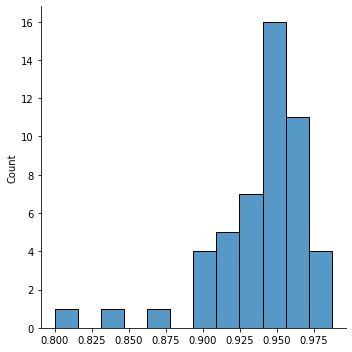

In [14]:
sns.displot(read_score("answer_similarity"))

<Axes: >

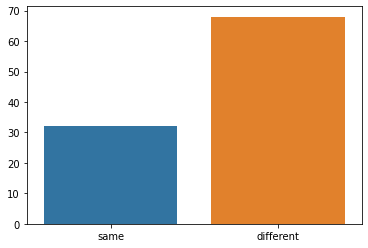

In [26]:
sns.barplot(x=["same","different"],y=[32,68])

In [20]:
sns.barplot?